## **Fundamentos de Analitica II**
### **Asignación:** Comparación de métodos de pronósticos simples de suavización para series de tiempo


Información relevante: Se trabaja con un pequeño dataset con datos de empleo. Y se explora la variable "Ocupados" en miles de personas.

### **1. Cargue de librerias principales**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose # Para gráficas de descomposición de componentes de la serie de tiempo
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # Holt-Winters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holt-Winters Doble y Triple
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error

In [2]:
# Pre-ajustes de diseño
sns.set_style("whitegrid")

### **2. Cargue de datos**

In [3]:
df = pd.read_excel("Data/datosEmpleo.xlsx", index_col="mes", date_parser="mes")
df.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


In [4]:
# Rango de datos
print(f"Inicio: {min(df.index)}. Fin: {max(df.index)}")

Inicio: 2001-01-01 00:00:00. Fin: 2019-04-01 00:00:00


Shape:  (220, 4)


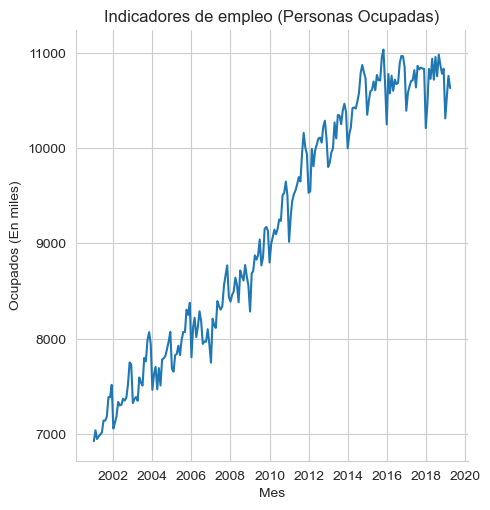

In [5]:
# Exploración de serie temporal
print("Shape: ", df.shape)
sns.relplot(data = df, x = "mes", y = "Ocupados", kind = "line")
plt.ylabel("Ocupados (En miles)")
plt.xlabel("Mes")
plt.title("Indicadores de empleo (Personas Ocupadas)")
plt.show()

### **3. Descomponiendo la serie**

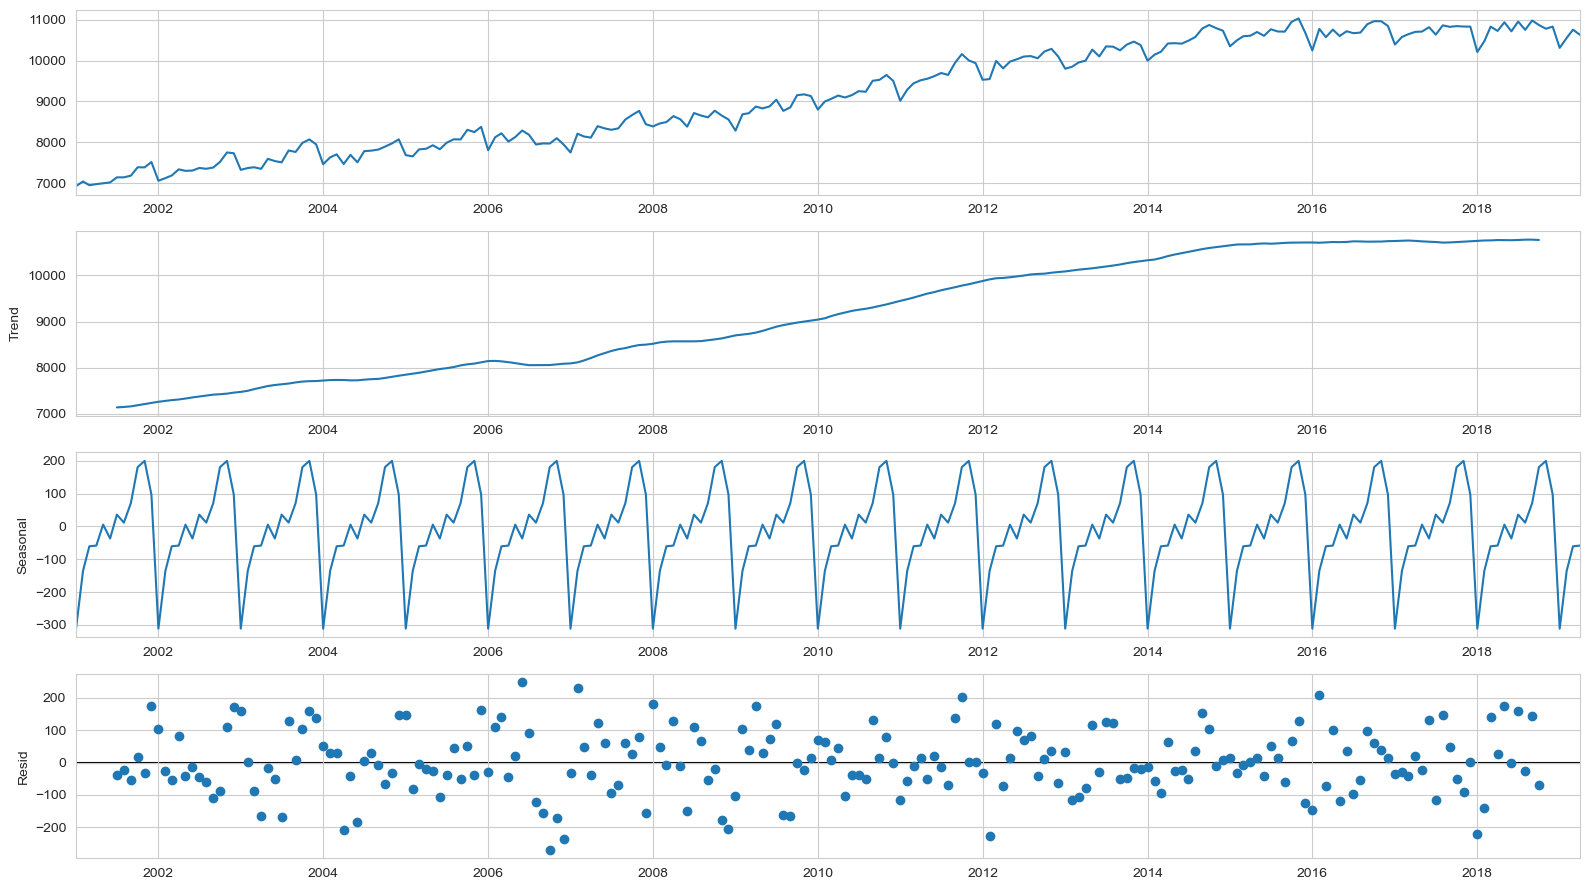

In [6]:
# Se descompone la serie en sus componentes principales: Tendencia, Estacionalidad, y Componente Puramente Aleatorio.

components = seasonal_decompose(df[["Ocupados"]], model = "additive")
figure = components.plot()
figure.set_size_inches((16,9))
figure.tight_layout()
plt.show()

In [7]:
# Extracción númerica de los componentes
components_seasonal = components.seasonal
components_trend = components.trend
components_resid = components.resid

C:\Windows\Temp\ipykernel_22812\1954322673.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)


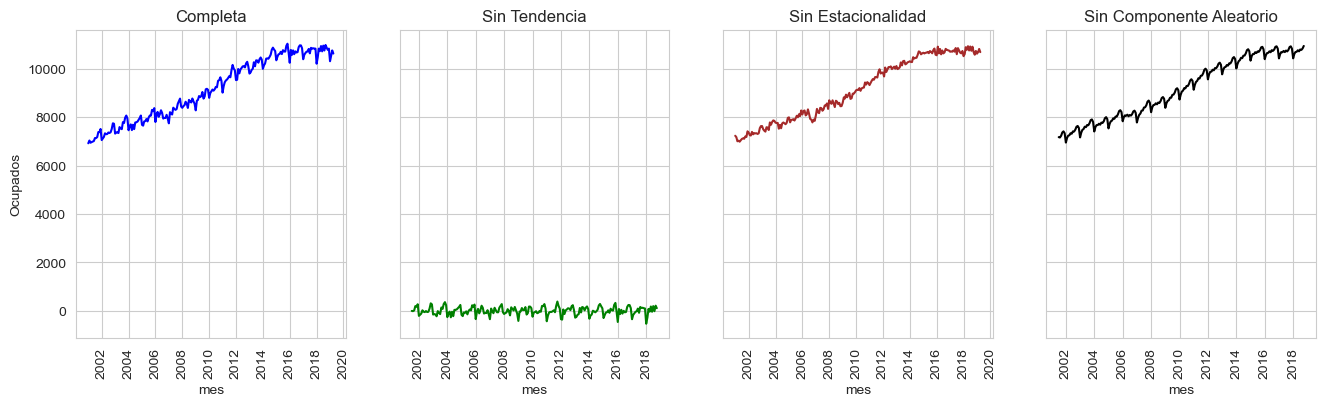

In [8]:
# Visualización de afectación de componentes
df['oc_out_trend'] = df['Ocupados'] - components_trend
df['oc_out_seasonal'] = df['Ocupados'] - components_seasonal
df['oc_out_resid'] = df['Ocupados'] - components_resid


fig, axs = plt.subplots(1,4, figsize = (16,4), sharey = True)
sns.lineplot(x = "mes", y = "Ocupados", data = df, ax = axs[0], color = "blue")
axs[0].set_title("Completa")
sns.lineplot(x = "mes", y = "oc_out_trend", data = df, ax = axs[1], color = "green")
axs[1].set_title("Sin Tendencia")
sns.lineplot(x = "mes", y = "oc_out_seasonal", data = df, ax = axs[2], color = "brown")
axs[2].set_title("Sin Estacionalidad")
sns.lineplot(x = "mes", y = "oc_out_resid", data = df, ax = axs[3], color = "black")
axs[3].set_title("Sin Componente Aleatorio")

for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()


### **4. Aplicación de métodos de suavización**

Dataset de entrenamiento:
 Inicio 2001-01-01 00:00:00, Fin 2018-04-01 00:00:00
Dataset de prueba:
 Inicio 2001-01-01 00:00:00, Fin 2018-04-01 00:00:00


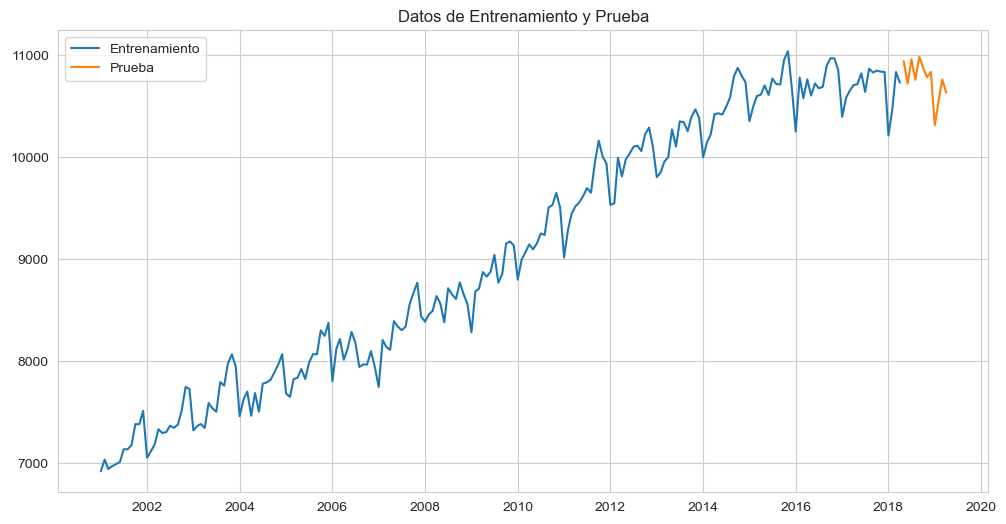

In [9]:
# Separación de datos de entrenamiento
train_len = df.shape[0] - 12 # Menos 1 año
train_oc = df[['Ocupados']][:train_len]
test_oc = df[['Ocupados']][train_len:]

# Check
print(f"Dataset de entrenamiento:\n Inicio {min(train_oc.index)}, Fin {max(train_oc.index)}")
print(f"Dataset de prueba:\n Inicio {min(train_oc.index)}, Fin {max(train_oc.index)}")

fig  = plt.figure(figsize=(12,6))
plt.plot(train_oc, label = "Entrenamiento")
plt.plot(test_oc, label = "Prueba")
plt.title("Datos de Entrenamiento y Prueba")
plt.legend()
plt.show()

### 4.1. Promedio móvil

Formulación:

$$ F_{t + 1}=\frac{Y_{t} + Y_{t-1} + Y_{t-(k-1)} }{ k} $$

Dónde,

$Y_{t}$ = Observación en el período t

$F_{t}$ = Pronóstico en el período t

${k}$ = Número de periodos móviles históricos a considerar

In [10]:
# Promedio moviles con k de 2 a 5

move_avgs = {}
k = 2
while  k<= 5:
    move_avgs[k] = train_oc.shift().rolling(k, min_periods = 2).mean()
    k += 1

In [11]:
# Función de predicción

def make_forecast(data_p, w, h): # Función de predicción con promedio móvil. data_p = datos de variable, w = k, h = horizonte (número de periodos a predecir)
    data = data_p.copy()
    for p in range(1, h+1):
        ind = data.index[-1]        
        value = ind + pd.DateOffset(months=1)
        data.loc[value] = data[-w:].mean()
    return data[-h:]

In [12]:
# Predicción de 12 meses

pred_move_avgs = {}

for k in move_avgs.keys():
    pred_move_avgs[k] = make_forecast(train_oc, k, 12)

In [40]:
# Calculando RMSE
rmse_move_avgs = {}

for k, pred in pred_move_avgs.items():
    rmse_move_avgs[k] = np.sqrt(mean_squared_error(test_oc, pred))

#Resultados
rmse_move_avgs

{2: 180.61405651284463,
 3: 190.8075001193029,
 4: 218.76010738130725,
 5: 221.86244433696749}

In [43]:
# RMSE de todos los modelos
RMSEs = []
RMSEs = pd.DataFrame({"Técnica": ["Promedio Móvil de Segundo Nivel"], "RMSE": [rmse_move_avgs[2]]})
RMSEs

,Técnica,RMSE
0,Promedio Móvil de Segundo Nivel,180.614057


**Mejor k**: 2

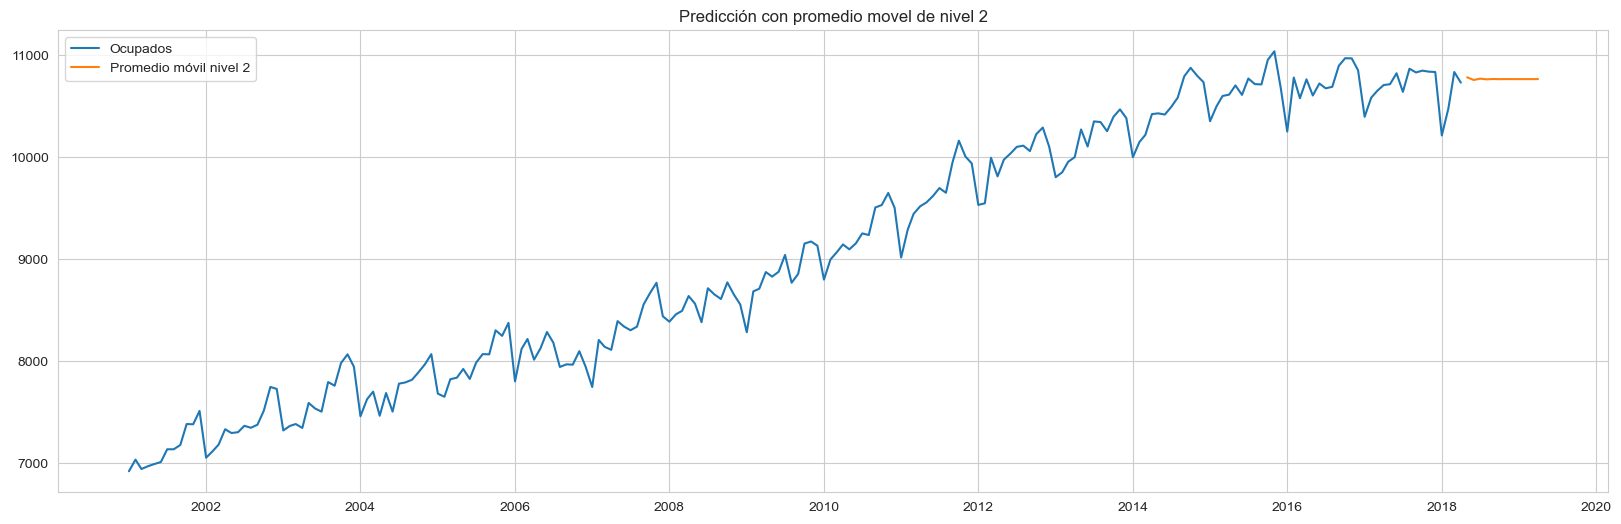

In [15]:
# Visualización de predicción con k = 2

fig = plt.figure(figsize = (20,6))
plt.plot(train_oc, label = "Ocupados")
plt.plot(pred_move_avgs[2], label = "Promedio móvil nivel 2")
plt.title("Predicción con promedio movel de nivel 2")
plt.legend()
plt.show()

### **4.2 Suavización Exponencial Simple**

In [16]:
# Construcción
ets_model = ETSModel(endog=train_oc["Ocupados"],error="add")
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)
limits = ci.predicted_mean


preds = pd.concat([limits, conf_forecast], axis = 1)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

            Point_forecast      lower_95      upper_95
2018-05-01    10720.369929  10363.684215  11077.055642
2018-06-01    10720.369929  10295.289386  11145.450471
2018-07-01    10720.369929  10236.466801  11204.273056
2018-08-01    10720.369929  10184.057514  11256.682343
2018-09-01    10720.369929  10136.332451  11304.407406
2018-10-01    10720.369929  10092.223016  11348.516842
2018-11-01    10720.369929  10051.014034  11389.725823
2018-12-01    10720.369929  10012.198987  11428.540870
2019-01-01    10720.369929   9975.403586  11465.336271
2019-02-01    10720.369929   9940.341967  11500.397890
2019-03-01    10720.369929   9906.789945  11533.949912
2019-04-01    10720.369929   9874.567848  11566.172009


c:\Users\Victus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


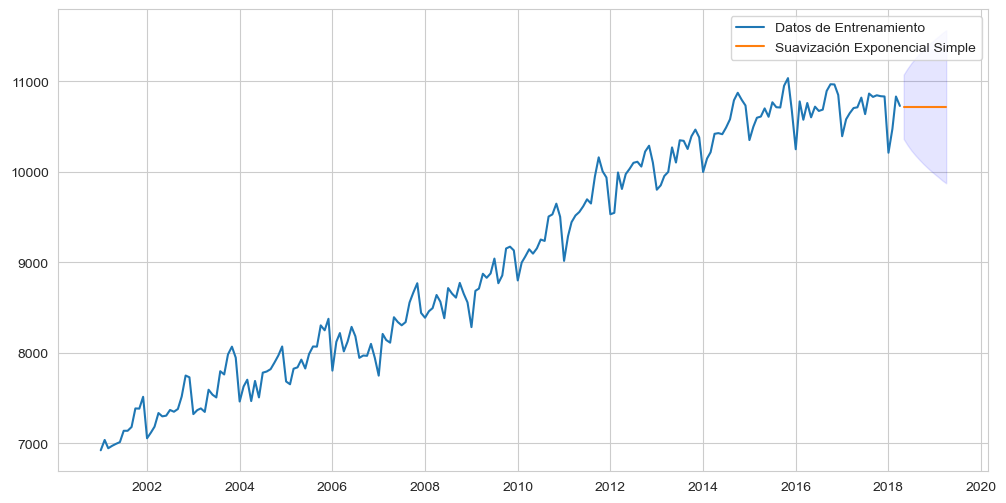

In [17]:
#Visualización de modelo
fig = plt.figure(figsize=(12, 6))
plt.plot(train_oc,label="Datos de Entrenamiento")
plt.plot(preds['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(preds.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [18]:
#Alpha
ets_result.alpha

0.64828262016549

In [44]:
# RMSE
rmse_ses = np.sqrt(mean_squared_error(test_oc,point_forecast))
RMSEs = RMSEs.append({"Técnica":"Suavización Lineal Simple", "RMSE": rmse_ses}, ignore_index=True)
RMSEs

C:\Windows\Temp\ipykernel_22812\946898153.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RMSEs = RMSEs.append({"Técnica":"Suavización Lineal Simple", "RMSE": rmse_ses}, ignore_index=True)


,Técnica,RMSE
0,Promedio Móvil de Segundo Nivel,180.614057
1,Suavización Lineal Simple,210.477428


### **4.3 Suavización Exponencial Lineal (Holt)**

In [25]:
ets_model = ETSModel(endog=train_oc["Ocupados"],error="mul",trend="mul")
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)
limits = ci.predicted_mean


preds_holt = pd.concat([limits, conf_forecast], axis = 1)
preds_holt.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_holt)

            Point_forecast      lower_95      upper_95
2018-05-01    10749.538883  10351.612325  11172.379261
2018-06-01    10773.218979  10298.082639  11235.741780
2018-07-01    10796.951239  10308.996803  11378.483703
2018-08-01    10820.735779  10296.917651  11426.771068
2018-09-01    10844.572714  10232.996579  11458.274787
2018-10-01    10868.462159  10277.317930  11593.528791
2018-11-01    10892.404230  10221.590020  11624.903605
2018-12-01    10916.399042  10195.271780  11662.894489
2019-01-01    10940.446713  10180.865254  11738.942465
2019-02-01    10964.547358  10185.803936  11799.046262
2019-03-01    10988.701095  10145.568242  11890.820085
2019-04-01    11012.908039  10127.498526  11879.552691


c:\Users\Victus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


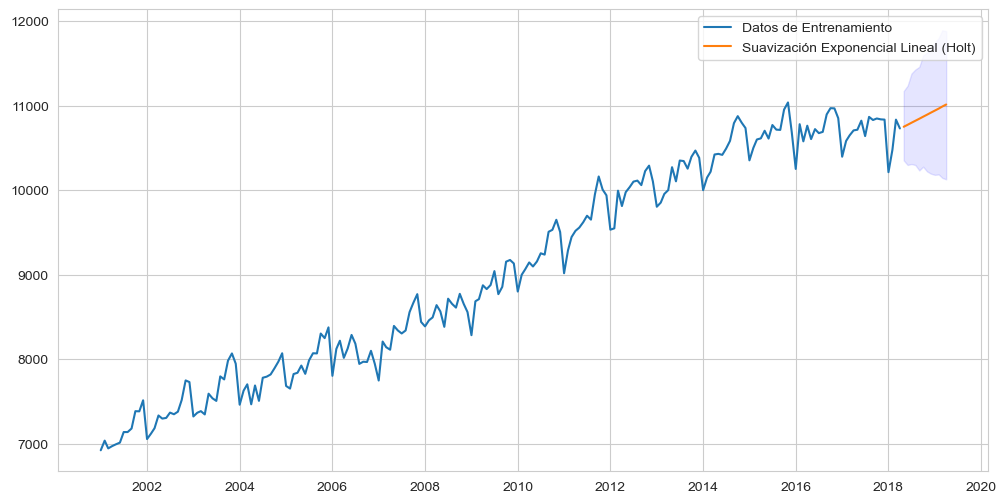

In [26]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_oc,label="Datos de Entrenamiento")
plt.plot(preds_holt['Point_forecast'],label="Suavización Exponencial Lineal (Holt)")
plt.fill_between(preds_holt.index ,preds_holt['lower_95'], preds_holt['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [31]:
# Alpha y Beta
print(ets_result.alpha,ets_result.beta)

0.3479474818436694 3.4794748184366945e-05


In [45]:
# RMSE
rmse_holt = np.sqrt(mean_squared_error(test_oc,preds_holt['Point_forecast']))
RMSEs = RMSEs.append({"Técnica":"Suavización Exponencial Lineal (Holt)", "RMSE": rmse_holt}, ignore_index=True)
RMSEs

C:\Windows\Temp\ipykernel_22812\4153535305.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RMSEs = RMSEs.append({"Técnica":"Suavización Exponencial Lineal (Holt)", "RMSE": rmse_holt}, ignore_index=True)


,Técnica,RMSE
0,Promedio Móvil de Segundo Nivel,180.614057
1,Suavización Lineal Simple,210.477428
2,Suavización Exponencial Lineal (Holt),268.074947


### **4.3 Suavización Exponencial de Winters (Holt-Winters)**

In [28]:
ets_model = ETSModel(endog=train_oc["Ocupados"],error="add",trend="add",seasonal="add" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

            Point_forecast      lower_95      upper_95
2018-05-01    10778.682274  10522.777227  11034.587321
2018-06-01    10842.441749  10571.485349  11113.398149
2018-07-01    10833.155518  10547.938173  11118.372864
2018-08-01    10942.111838  10643.310761  11240.912915
2018-09-01    10997.498455  10685.702337  11309.294572
2018-10-01    11095.847565  10771.574314  11420.120815
2018-11-01    11114.796991  10778.506863  11451.087118
2018-12-01    11011.823494  10663.929049  11359.717940
2019-01-01    10524.710630  10165.584431  10883.836830
2019-02-01    10802.734302  10432.714983  11172.753621
2019-03-01    10952.739188  10572.136307  11333.342068
2019-04-01    10962.073826  10571.171797  11352.975856


c:\Users\Victus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


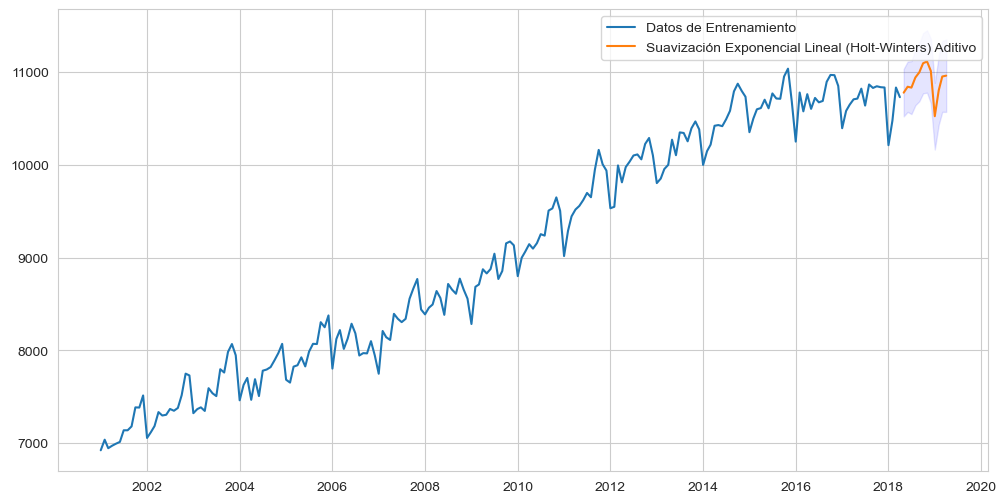

In [30]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_oc,label="Datos de Entrenamiento")
plt.plot(preds_hw_add['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Aditivo")
plt.fill_between(preds_hw_add.index ,preds_hw_add['lower_95'], preds_hw_add['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [33]:
#Alpha, Beta, Gamma
print(ets_result.alpha,ets_result.beta,ets_result.gamma)

0.3479474818436694 3.4794748184366945e-05 0.32233428809919495


In [46]:
# RMSE
rmse_hw_add = np.sqrt(mean_squared_error(test_oc,preds_hw_add['Point_forecast']))
RMSEs = RMSEs.append({"Técnica":"SEL (Holt-Winters) Aditivo", "RMSE": rmse_hw_add}, ignore_index=True)
RMSEs

C:\Windows\Temp\ipykernel_22812\3507703568.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RMSEs = RMSEs.append({"Técnica":"SEL (Holt-Winters) Aditivo", "RMSE": rmse_hw_add}, ignore_index=True)


,Técnica,RMSE
0,Promedio Móvil de Segundo Nivel,180.614057
1,Suavización Lineal Simple,210.477428
2,Suavización Exponencial Lineal (Holt),268.074947
3,SEL (Holt-Winters) Aditivo,210.477428


In [55]:
# Multiplicativo

ets_model = ETSModel(endog=train_oc["Ocupados"],error="add",trend=None,seasonal="mul" , )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_mul = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_mul.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_mul)

            Point_forecast      lower_95      upper_95
2018-05-01    10787.445267  10560.995963  11016.334047
2018-06-01    10757.065460  10488.432677  11031.655300
2018-07-01    10832.086266  10525.058167  11140.210575
2018-08-01    10816.529660  10510.878389  11162.757059
2018-09-01    10878.550603  10513.120969  11237.925893
2018-10-01    11021.781085  10636.367058  11395.979747
2018-11-01    11036.623635  10612.492536  11458.457263
2018-12-01    10910.527774  10472.627001  11339.764956
2019-01-01    10434.469894  10022.706581  10873.338539
2019-02-01    10638.037733  10160.739290  11111.563676
2019-03-01    10721.751805  10237.393353  11205.267674
2019-04-01    10730.726144  10226.548358  11243.915893


c:\Users\Victus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


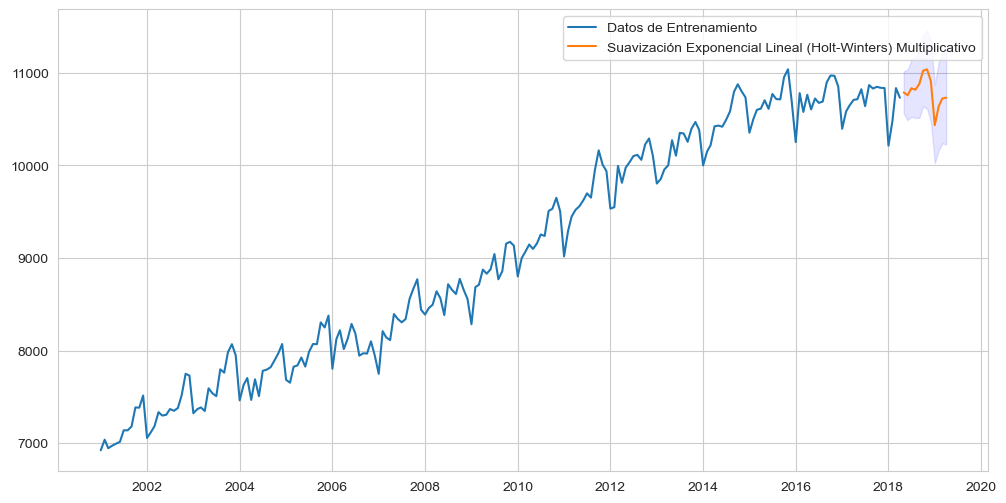

In [56]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_oc,label="Datos de Entrenamiento")
plt.plot(preds_hw_mul['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Multiplicativo")
plt.fill_between(preds_hw_mul.index ,preds_hw_mul['lower_95'], preds_hw_mul['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [59]:
#Alpha, Gamma
print(ets_result.alpha,ets_result.gamma)

0.6067559392453122 3.932440607546878e-05


In [53]:
# RMSE
rmse_hw_mul = np.sqrt(mean_squared_error(test_oc,preds_hw_mul['Point_forecast']))
RMSEs = RMSEs.append({"Técnica":"SEL (Holt-Winters) Multiplicativo", "RMSE": rmse_hw_mul}, ignore_index=True)
RMSEs

C:\Windows\Temp\ipykernel_22812\1281852877.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RMSEs = RMSEs.append({"Técnica":"SEL (Holt-Winters) Multiplicativo", "RMSE": rmse_hw_mul}, ignore_index=True)


,Técnica,RMSE
0,Promedio Móvil de Segundo Nivel,180.614057
1,Suavización Lineal Simple,210.477428
2,Suavización Exponencial Lineal (Holt),268.074947
3,SEL (Holt-Winters) Aditivo,210.477428
4,SEL (Holt-Winters) Multiplicativo,122.360681


**Mejor modelo**: SEL (Holt-Winters) Multiplicativo

### **5. Predicción** 

In [64]:
# Entrenamiento de modelo
final_model = ETSModel(endog = df["Ocupados"], error = "add", trend = "add", seasonal = "mul")
final_model_fit = final_model.fit_constrained({"smoothing_level": 0.6067559392453122, "smoothing_seasonal": 3.932440607546878e-05})

c:\Users\Victus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
# Predicción: Función de predicción

def make_forecast(data_p, h): #data_p = datos de variable, w = k, h = horizonte (número de periodos a predecir)
    data = data_p.copy()
    for p in range(1, h):
        ind = data.index[-1]        
        value = ind + pd.DateOffset(months=1)
        data.loc[value] = data[-w:].mean()
    return data[-h:]

In [73]:
# Predicción: Próximos 6 meses
forecast_6Months = final_model_fit.forecast(steps = 6)
forecast_6Months

2019-05-01    10765.679756
2019-06-01    10740.308798
2019-07-01    10846.843679
2019-08-01    10836.231917
2019-09-01    10930.003215
2019-10-01    11072.620807
Freq: MS, Name: simulation, dtype: float64

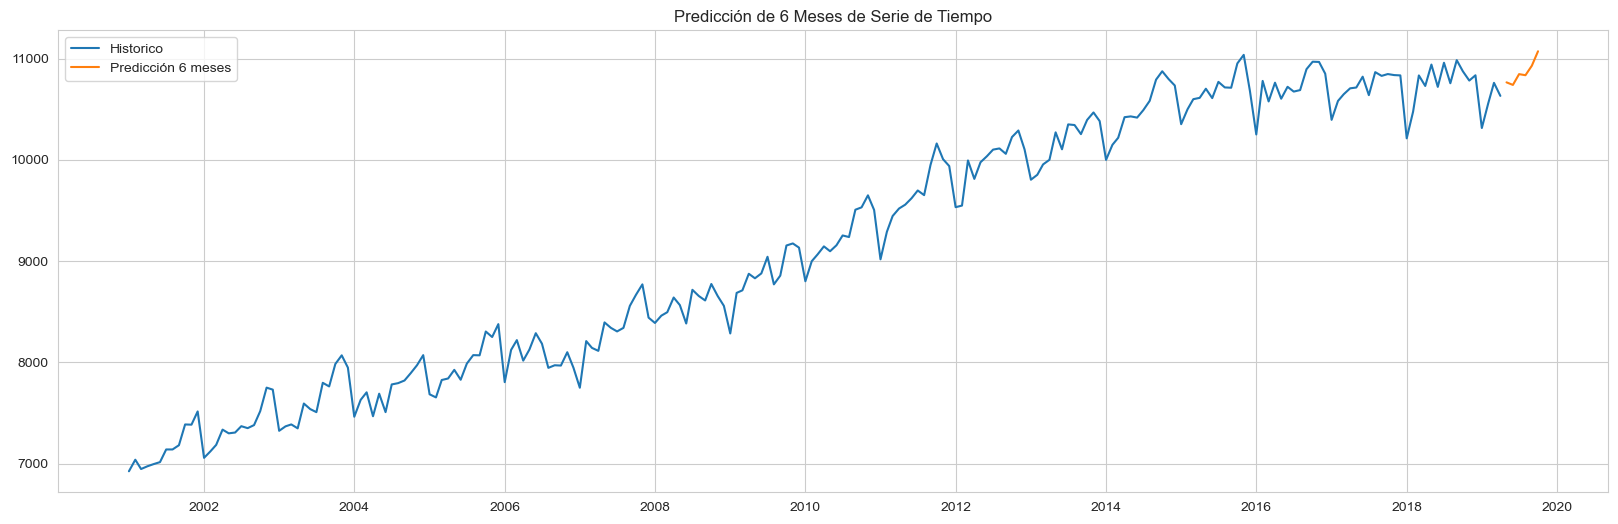

In [75]:
#Visualización de resultados
fig = plt.figure(figsize = (20,6))
plt.plot(df['Ocupados'], label = "Historico")
plt.plot(forecast_6Months, label = "Predicción 6 meses")
plt.legend()
plt.title("Predicción de 6 Meses de Serie de Tiempo")
plt.show()